In [26]:
!pip install yfinance ta backtrader

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import load_model
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [28]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Colab Notebooks/COMP5513'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/Colab Notebooks/COMP5513"


In [29]:
#model = load_model('lstm-cnn.h5')
model = load_model('lstm-cnn-20220312.h5')  #updated model

In [30]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(start="2020-12-31", end="2022-02-01")
#df = stock.history(start="2008-12-31", end="2022-12-31")#stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [31]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['macd'] = macd.macd()
stock_data['macd_signal'] = macd.macd_signal()
stock_data['rsi'] = rsi.rsi()
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['ichimoku_a'] = ichi.ichimoku_a()
stock_data['ichimoku_b'] = ichi.ichimoku_b()
stock_data['ichimoku_base_line'] = ichi.ichimoku_base_line()
stock_data['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data = stock_data.fillna(0)

#stock_data = stock_data[:-1]
stock_orig = stock_data.copy()

#stock = stock[250:]
stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line,SMA_10,SMA_30,SMA_50
Date,,,,,,,,,,,,,,,,,,
2020-12-31,27.440001,27.440001,27.440001,27.440001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.440001,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-04,27.360001,27.680000,27.320000,27.639999,228402605,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.500000,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-05,27.480000,27.879999,27.340000,27.740000,139782911,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.599999,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-06,27.799999,27.940001,27.580000,27.840000,145424037,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000,0.000,0.000000,0.0000
2021-01-07,27.840000,27.920000,27.620001,27.700001,134972086,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000,0.000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,24.360001,24.520000,24.139999,24.400000,293789413,0.238102,0.130152,53.823723,24.009,25.261547,22.756453,24.290000,24.360000,23.970000,24.610001,24.570,23.796000,24.0784
2022-01-26,24.500000,24.620001,24.260000,24.400000,180807801,0.219607,0.148043,53.823723,24.069,25.274883,22.863116,24.300001,24.360000,23.990001,24.610001,24.560,23.817333,24.0504
2022-01-27,24.260000,24.260000,23.700001,23.920000,291671561,0.164324,0.151299,45.965314,24.101,25.254254,22.947746,24.200001,24.360000,23.990001,24.410001,24.496,23.828667,24.0132


In [32]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values

stock_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line,SMA_10,SMA_30,SMA_50
Date,,,,,,,,,,,,,,,,,,
2020-12-31,0.539380,0.519705,0.584810,0.544365,0.000000,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.605214,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,0.529833,0.549261,0.569620,0.568345,0.582183,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.616387,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.544153,0.573892,0.572152,0.580336,0.356297,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.635009,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-06,0.582339,0.581281,0.602532,0.592326,0.370676,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-07,0.587112,0.578818,0.607595,0.575540,0.344035,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,0.171838,0.160099,0.167089,0.179856,0.748850,0.704737,0.628666,0.556715,0.799580,0.803265,0.791290,0.804038,0.031657,0.800334,0.805828,0.803414,0.797079,0.815962
2022-01-26,0.188544,0.172414,0.182279,0.179856,0.460867,0.689633,0.645742,0.556715,0.801579,0.803689,0.794999,0.804369,0.031657,0.801002,0.805828,0.803087,0.797794,0.815014
2022-01-27,0.159905,0.128079,0.111393,0.122302,0.743452,0.644485,0.648850,0.475433,0.802644,0.803033,0.797942,0.801059,0.031657,0.801002,0.799280,0.800994,0.798173,0.813753


# Specify the period for back testing (using 2021 data)

In [33]:
stock_data = stock_data.loc['2021-01-01':'2022-01-01']
stock_orig = stock_orig.loc['2021-01-01':'2022-01-01']

In [34]:
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line', 'SMA_10', 'SMA_30', 'SMA_50'],1)

features = 11 #including the close price

window_size = 60
week = 7
X = []
Y = []
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

test_X = np.array(X)
test_label = np.array(Y)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)

stock_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,High,Low,Close,macd,macd_signal,rsi,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line
Date,,,,,,,,,,,
2021-01-04,0.549261,0.569620,0.568345,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.616387,0.000000
2021-01-05,0.573892,0.572152,0.580336,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.635009,0.000000
2021-01-06,0.581281,0.602532,0.592326,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000
2021-01-07,0.578818,0.607595,0.575540,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.640596,0.000000
2021-01-08,0.603448,0.620253,0.613909,0.510289,0.504442,0.000000,0.000000,0.000000,0.000000,0.657356,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,0.022168,0.073418,0.059952,0.150792,0.084891,0.406502,0.779486,0.796500,0.785005,0.124767,0.802671
2021-12-28,0.029557,0.053165,0.062350,0.171014,0.089497,0.411048,0.777835,0.795801,0.784343,0.124767,0.802671
2021-12-29,0.019704,0.040506,0.035971,0.176391,0.094438,0.378580,0.778013,0.794147,0.780536,0.124767,0.798331


<IPython.core.display.Javascript object>

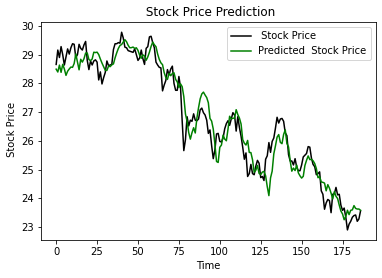

In [35]:
predicted  = model.predict(test_X)

real_price = stock_orig.iloc[window_size:,3].values
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()


# MSE between predicted and actual stock price

In [36]:
rp = real_price.reshape(187,1)
difference_array = np.subtract(rp, predicted)
squared_array = np.square(difference_array)
mse = squared_array.mean()

mse

0.25296407177636787

# Prepare the testing dataset for backtesting

In [37]:
testing_data = stock_orig.iloc[-len(predicted):,:]
testing_data = testing_data.assign(predict=predicted)
testing_data['predict'] = testing_data['predict'].shift(-1)
testing_data = testing_data[:-1]
testing_data

,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line,SMA_10,SMA_30,SMA_50,predict
Date,,,,,,,,,,,,,,,,,,,
2021-03-31,29.000000,29.040001,28.600000,28.660000,51539018,-0.253717,-0.214346,44.763098,28.972,29.784345,28.159655,29.020000,29.56,29.390000,28.650001,28.768,29.352667,29.5012,28.396370
2021-04-01,28.820000,29.219999,28.760000,29.160000,119073490,-0.206401,-0.212757,51.080581,28.959,29.750300,28.167700,28.895000,29.56,29.200001,28.590000,28.718,29.298667,29.4884,28.635967
2021-04-07,29.320000,29.360001,28.860001,28.900000,70149604,-0.187719,-0.207749,48.005915,28.942,29.722963,28.161037,28.755001,29.56,28.940001,28.570001,28.690,29.235333,29.4648,28.384439
2021-04-08,28.760000,29.340000,28.760000,29.280001,61542723,-0.140629,-0.194325,52.505582,28.969,29.757464,28.180536,28.755001,29.56,28.940001,28.570001,28.708,29.194000,29.4492,28.661938
2021-04-09,29.320000,29.320000,28.860001,29.000000,109682038,-0.124469,-0.180354,49.131574,28.971,29.759566,28.182434,28.755001,29.56,28.940001,28.570001,28.728,29.134000,29.4368,28.502369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,23.299999,23.400000,23.180000,23.340000,96107039,-0.463370,-0.439414,38.042379,23.753,24.577550,22.928450,23.930000,24.86,24.190000,23.670000,23.514,24.266000,24.8976,23.745634
2021-12-24,23.400000,23.400000,23.400000,23.400000,0,-0.440205,-0.439573,39.301024,23.710,24.513741,22.906259,23.715000,24.86,24.040000,23.389999,23.442,24.196000,24.8460,23.647844
2021-12-28,23.400000,23.459999,23.240000,23.420000,89272826,-0.415444,-0.434747,39.740476,23.674,24.461817,22.886183,23.695000,24.86,24.040000,23.349999,23.370,24.124667,24.7924,23.626474


In [38]:
class MyBackTest(object):
  def __init__(self, test_df, trade_ratio=1, kelly=False, skip=False, init_cap=1000000):
    self.money_sequence = []
    self.init_capital = init_cap
    self.init_state = 0
    self.init_stock = 0
    self.cash_in_hand = init_capital
    self.testing_data = test_df
    self.trade_ratio = trade_ratio
    self.kelly = kelly
    self.skip = skip
    self.win_ratio = 0.5
    self.win_loss_ratio = 0.0
    self.profit_cnt = 0
    self.no_of_trade = 0
    self.money_sequence.append(self.cash_in_hand)
  
  def run(self):
    count = 0
    p_signal = 0
    p_macd = 0
    for index, row in self.testing_data.iterrows():
      if count == 0:
        p_signal = row['macd_signal']
        p_macd = row['macd']
        count += 1
        prev_r = row
        continue
      if count < len(predicted)-1:
        rsi_sig = self.rsi_signal(row['rsi'])
        ml_sig = self.predict_signal(row['Close'], row['predict'], bypass=self.skip)
        macd_sig = self.macd_signal(row['macd'], p_macd, row['macd_signal'], p_signal)
        bollinger_sig = self.bollinger_signal(prev_r, row)
        sma_sig = self.sma_signal(row['Close'], row['SMA_50'])
        #print(rsi_sig, macd_sig, bollinger_sig, ml_sig, row['Close'], predicted[count][0])
        ratio=self.trade_ratio
        if self.kelly:    #basic kelly criterion
          if self.no_of_trade > 0 and self.win_loss_ratio != 0:
            ratio = self.win_ratio - (1-self.win_ratio)/self.win_loss_ratio
          else:
            ratio = 0.5
        remain, lots, state = self.trade(row['Close'],self.cash_in_hand, 
                                    self.init_state, self.init_stock, 
                                    rsi_sig,macd_sig,ml_sig,bollinger_sig,
                                    sma_sig, trade_ratio=ratio)
        if (remain != None):
          self.cash_in_hand = remain
          if state == 1 and self.init_state == 1:
            self.init_stock = self.init_stock + lots
          else:
            self.init_stock = lots
          self.init_state = state
          print("Trading at: ", index, " long " 
                if self.init_state == 1 else " short ", round(row['Close'],2), 
                ',Remain cash',round(self.cash_in_hand,2),',current stock ', self.init_stock, 
                ', Trading ratio ', ratio)
        if state == 0:
          self.no_of_trade += 1
          if self.money_sequence[-1] < remain:
            self.profit_cnt+=1
          self.win_ratio = self.profit_cnt/self.no_of_trade
          if (self.no_of_trade-self.profit_cnt) != 0:
            self.win_loss_ratio = self.profit_cnt/(self.no_of_trade-self.profit_cnt)
          self.money_sequence.append(remain)
        p_signal = row['macd_signal']
        p_macd = row['macd']
        count += 1
      prev_r = row

    if self.init_stock > 0:
      market_money = self.cash_in_hand+row['Close']*self.init_stock*500
      self.money_sequence.append(market_money)

  def rsi_signal(self, rsi):
    rsi_val = float(rsi)
    if rsi_val >= 70:
      return -1
    if rsi_val <= 30:
      return 1
    else:
      return 0

  def predict_signal(self, current, predict, threshold=0.05, bypass=False):
    diff = (current - predict)/current
    # print(diff)
    #if True:
    if abs(diff) >= threshold or bypass:
      if np.sign(diff) > 0:
        return -1
      else:
        return 1
    else:
      return 0

  def sma_signal(self, curr_price, sma):
    if (curr_price > sma):
      return -1
    elif (curr_price < sma):
      return 1
    else:
      return 0

  #moving average -> may test later
  #all in/ all out Vs. 
  def trade(self, price, capital, state, stock, rsi, macd, ml, bb, sma, trade_ratio, threshold=0.2, min_lot=500):
    remain = 0
    score = rsi*0.2+macd*0.2+bb*0.2+ml*0.2+sma*0.2
    #print(score)
    if score > threshold and state != 1:  #disable the long and short order
      lots = math.floor(capital*trade_ratio / (price*min_lot))
      amount = price * lots * min_lot
      if lots > 1 and capital > amount:
        remain = capital - amount
      else:
        return None, None, None
      return remain, lots, 1
    elif score <= -0.2 and state != 0:
      values = capital + price * stock * min_lot
      return values, 0, 0
    else:
      return None, None, None

  def macd_signal(self, macd, prev_macd, signal, prev_signal):
    if prev_signal > prev_macd and signal < macd:
      return 1
    elif prev_signal < prev_macd and signal > macd:
      return -1
    else:
      return 0

  def bollinger_signal(self, prev_row, curr_row):
    if prev_row['Close'] < prev_row['bollinger_lbond'] and curr_row['Close'] > curr_row['bollinger_lbond']:
      return 1
    elif prev_row['Close'] > prev_row['bollinger_hband'] and curr_row['Close'] < curr_row['bollinger_hband']:
      return -1
    else:
      return 0

# All in Trading Strategy

In [39]:
init_capital=1000000
my_bt = MyBackTest(test_df=testing_data, trade_ratio=1, init_cap=init_capital, skip=True)
my_bt.run()
my_bt.money_sequence

Trading at:  2021-04-30 00:00:00  long  28.8 ,Remain cash 6400.03 ,current stock  69 , Trading ratio  1
Trading at:  2021-05-25 00:00:00  short  29.18 ,Remain cash 1013110.04 ,current stock  0 , Trading ratio  1
Trading at:  2021-06-16 00:00:00  long  28.8 ,Remain cash 5110.06 ,current stock  70 , Trading ratio  1
Trading at:  2021-06-18 00:00:00  short  29.16 ,Remain cash 1025710.06 ,current stock  0 , Trading ratio  1
Trading at:  2021-06-21 00:00:00  long  28.86 ,Remain cash 1180.04 ,current stock  71 , Trading ratio  1
Trading at:  2021-06-23 00:00:00  short  29.22 ,Remain cash 1038490.01 ,current stock  0 , Trading ratio  1
Trading at:  2021-07-05 00:00:00  long  28.64 ,Remain cash 7450.03 ,current stock  72 , Trading ratio  1
Trading at:  2021-10-18 00:00:00  short  26.1 ,Remain cash 947050.05 ,current stock  0 , Trading ratio  1
Trading at:  2021-11-19 00:00:00  long  25.18 ,Remain cash 2800.04 ,current stock  75 , Trading ratio  1
Trading at:  2021-11-22 00:00:00  short  25.1 ,

[1000000,
 1013110.0368499756,
 1025710.0582122803,
 1038490.0121688843,
 947050.0478744507,
 944050.0507354736,
 917870.038986206,
 915530.0598144531]

In [40]:
final_profit = my_bt.money_sequence[-1]/init_capital - 1
print("final profit is ", final_profit*100,"%")

final profit is  -8.446994018554687 %


# Basic Kelly Trading Strategy

In [41]:
init_capital=1000000
my_bt_kelly = MyBackTest(test_df=testing_data, kelly=True, init_cap=init_capital, skip=True)
my_bt_kelly.run()
my_bt_kelly.money_sequence

Trading at:  2021-04-30 00:00:00  long  28.8 ,Remain cash 510400.01 ,current stock  34 , Trading ratio  0.5
Trading at:  2021-05-25 00:00:00  short  29.18 ,Remain cash 1006460.02 ,current stock  0 , Trading ratio  0.5
Trading at:  2021-06-16 00:00:00  long  28.8 ,Remain cash 516860.03 ,current stock  34 , Trading ratio  0.5
Trading at:  2021-06-18 00:00:00  short  29.16 ,Remain cash 1012580.03 ,current stock  0 , Trading ratio  0.5
Trading at:  2021-06-21 00:00:00  long  28.86 ,Remain cash 507530.02 ,current stock  35 , Trading ratio  0.5
Trading at:  2021-06-23 00:00:00  short  29.22 ,Remain cash 1018880.01 ,current stock  0 , Trading ratio  0.5
Trading at:  2021-07-05 00:00:00  long  28.64 ,Remain cash 517680.02 ,current stock  35 , Trading ratio  0.5
Trading at:  2021-10-18 00:00:00  short  26.1 ,Remain cash 974430.02 ,current stock  0 , Trading ratio  0.5
Trading at:  2021-11-19 00:00:00  long  25.18 ,Remain cash 332340.02 ,current stock  51 , Trading ratio  0.6666666666666666
Trad

[1000000,
 1006460.018157959,
 1012580.0285339355,
 1018880.0058364868,
 974430.0231933594,
 972390.025138855,
 963550.0211715698]

In [42]:
final_profit = my_bt_kelly.money_sequence[-1]/init_capital - 1
print("final profit is ", final_profit*100,"%")

final profit is  -3.644997882843015 %


# Simulation Result

<IPython.core.display.Javascript object>

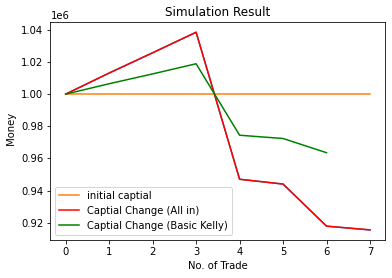

In [43]:
plt.plot(my_bt.money_sequence)

m_length = max(len(my_bt_kelly.money_sequence), len(my_bt.money_sequence))

x_coordinates = [i for i in range(m_length)]
y_coordinates = [1000000]*m_length
plt.plot(x_coordinates, y_coordinates, label = 'initial captial')
plt.plot(my_bt.money_sequence, color = 'red', label = 'Captial Change (All in)')
plt.plot(my_bt_kelly.money_sequence, color = 'green', label = 'Captial Change (Basic Kelly)')
plt.title('Simulation Result')
plt.xlabel('No. of Trade')
plt.ylabel(' Money')
plt.legend()
plt.show()

# Simulation Result by using BackTrader

In [44]:
testing_data.index.names = ['datetime']

In [45]:
# data feeds
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

class PandasData(btfeeds.PandasData):
    linesoverride = True  # discard usual OHLC structure
    # datetime must be present and last
    lines = ('datetime','open', 'high', 'low', 'close', 'volume',
             'macd','macd_signal','rsi','bollinger_mavg', 'bollinger_hband',
             'bollinger_lbond', 'ichimoku_a', 'ichimoku_b',
             'ichimoku_base_line', 'ichimoku_conversion_line',
             'SMA_10', 'SMA_30', 'SMA_50', 'predict')
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('macd', -1),
        ('macd_signal', -1),
        ('rsi', -1),
        ('bollinger_mavg', -1),
        ('bollinger_hband', -1),
        ('bollinger_lbond', -1),
        ('ichimoku_a', -1),
        ('ichimoku_b', -1),
        ('ichimoku_base_line', -1),
        ('ichimoku_conversion_line', -1),
        ('SMA_10', -1),
        ('SMA_30', -1),
        ('SMA_50', -1),
        ('predict', -1),
    )

trading_data = PandasData(dataname=testing_data, plot=True)

In [46]:
class MlTrading(bt.Strategy):
  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))
  
  params = dict(
        ma_period_short=5,
        ma_period_long=10
      )
  
  def __init__(self):
    self.closePrice = self.datas[0].close
    self.pred = self.datas[0].predict
    self.total_trade = 0

    sma10 = self.datas[0].SMA_10
    sma30 = self.datas[0].SMA_30
    predd = self.datas[0].predict
    self.sma_crossover = bt.ind.CrossOver(sma10, sma30)

    self.setsizer(sizer())  #all-in strategy

  def notify_trade(self, trade):
    if trade.isclosed:
      self.total_trade += 1
      self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))
   
  def next(self):
    cash_on_hand = self.broker.get_cash()
    self.size = math.floor(cash_on_hand / self.closePrice[0])
    # self.log(self.getposition().size)
    if not self.position and self.size > 0:
      if self.closePrice[0] < self.pred[0]:
        if self.closePrice[-1] < self.pred[-1]:
          self.size = math.floor(cash_on_hand / self.closePrice[0])
          self.log('BUY ' + ', Price: ' + str(self.closePrice[0]))
          self.buy(price=self.closePrice[0])
    elif self.closePrice[0] > self.pred[0]:  #self.sma_crossover < 0:
      self.log('SELL ' + ', Price: ' + str(self.closePrice[0]))
      self.close(price=self.closePrice[0])

In [47]:
class sizer(bt.Sizer):
  def _getsizing(self, comminfo, cash, data, isbuy):
    if isbuy:
      return math.floor(cash/data[1])
    else:
      return self.broker.getposition(data)

# All in *strategy*

--------------------
Starting backtesting with capital : 1000000.000000
--------------------
Trading Log
2021-05-03, BUY , Price: 28.479999542236328
2021-05-18, SELL , Price: 28.780000686645508
2021-05-20, OPERATION PROFIT, GROSS 0.02, NET 0.02
2021-05-24, BUY , Price: 28.65999984741211
2021-05-25, SELL , Price: 29.18000030517578
2021-05-26, OPERATION PROFIT, GROSS 0.52, NET 0.52
2021-06-04, BUY , Price: 29.239999771118164
2021-06-17, SELL , Price: 28.8799991607666
2021-06-18, OPERATION PROFIT, GROSS -0.40, NET -0.40
2021-06-22, BUY , Price: 28.65999984741211
2021-06-23, SELL , Price: 29.219999313354492
2021-06-24, OPERATION PROFIT, GROSS 0.42, NET 0.42
2021-07-02, BUY , Price: 28.739999771118164
2021-07-13, SELL , Price: 28.479999542236328
2021-07-14, OPERATION PROFIT, GROSS -0.26, NET -0.26
2021-07-20, BUY , Price: 27.760000228881836
2021-07-22, SELL , Price: 28.239999771118164
2021-07-23, OPERATION PROFIT, GROSS 0.34, NET 0.34
2021-07-26, BUY , Price: 26.700000762939453
2021-07-29, 

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

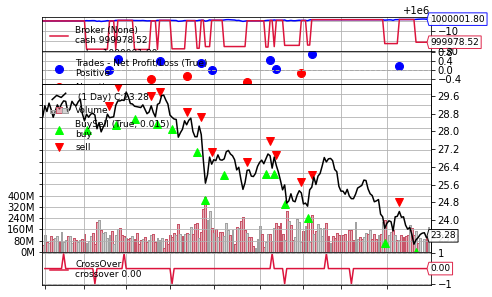

In [48]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000000)
cerebro.adddata(trading_data)
cerebro.addstrategy(MlTrading)
# cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
print('-'*20)
print('Starting backtesting with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
print("Trading Log")
cerebro.run()
print('-'*20)
print('Backtesting completed with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
cerebro.plot()

# from google.colab import files
# from IPython.display import Image
# chart_file = 'result.png'
# cerebro.plot()[0][0].savefig(chart_file, dpi=300)
# Image(open(chart_file, 'rb').read())

# 50% Fixed proportion trading

--------------------
Starting backtesting with capital : 1000000.000000
--------------------
Trading Log
2021-05-03, BUY , Price: 28.479999542236328
2021-05-18, SELL , Price: 28.780000686645508
2021-05-20, OPERATION PROFIT, GROSS 351.13, NET 351.13
2021-05-24, BUY , Price: 28.65999984741211
2021-05-25, SELL , Price: 29.18000030517578
2021-05-26, OPERATION PROFIT, GROSS 9075.04, NET 9075.04
2021-06-04, BUY , Price: 29.239999771118164
2021-06-17, SELL , Price: 28.8799991607666
2021-06-18, OPERATION PROFIT, GROSS -6904.41, NET -6904.41
2021-06-22, BUY , Price: 28.65999984741211
2021-06-23, SELL , Price: 29.219999313354492
2021-06-24, OPERATION PROFIT, GROSS 7345.76, NET 7345.76
2021-07-02, BUY , Price: 28.739999771118164
2021-07-13, SELL , Price: 28.479999542236328
2021-07-14, OPERATION PROFIT, GROSS -4567.95, NET -4567.95
2021-07-20, BUY , Price: 27.760000228881836
2021-07-22, SELL , Price: 28.239999771118164
2021-07-23, OPERATION PROFIT, GROSS 6156.38, NET 6156.38
2021-07-26, BUY , Pric

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

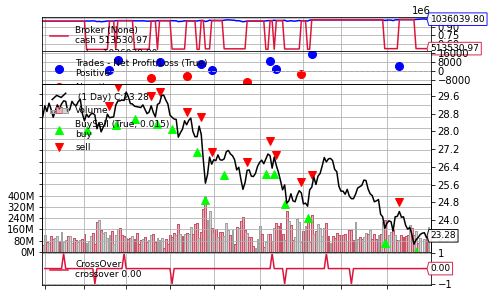

In [52]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000000)
cerebro.adddata(trading_data)
cerebro.addstrategy(MlTrading)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 50)
print('-'*20)
print('Starting backtesting with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
print("Trading Log")
cerebro.run()
print('-'*20)
print('Backtesting completed with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
cerebro.plot()

# from google.colab import files
# from IPython.display import Image
# chart_file = 'result.png'
# cerebro.plot()[0][0].savefig(chart_file, dpi=300)
# Image(open(chart_file, 'rb').read())

# Kelly strategy

In [ ]:
class MlKellyTrading(bt.Strategy):
  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))
  
  params = dict(
        ma_period_short=5,
        ma_period_long=10
      )
  
  def __init__(self):
    self.closePrice = self.datas[0].close
    self.pred = self.datas[0].predict

    sma10 = self.datas[0].SMA_10
    sma30 = self.datas[0].SMA_30
    predd = self.datas[0].predict
    self.sma_crossover = bt.ind.CrossOver(sma10, sma30)

    self.w = 0.5
    self.r = 0
    self.total_trade = 0
    self.win_cnt = 0

  def notify_trade(self, trade):
    if trade.isclosed:
      self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))
      self.total_trade += 1
      if trade.pnl > 0:
        self.win_cnt += 1
      self.w = self.win_cnt / self.total_trade
      if (self.total_trade-self.win_cnt) > 0:
        self.r = self.win_cnt / (self.total_trade-self.win_cnt)
  
  def next(self):
    cash_on_hand = self.broker.get_cash()
    if self.r > 0:
      kelly_proportion = self.w - (1-self.w) / self.r
    else:
      kelly_proportion = 0.5
    invest_amount = cash_on_hand * kelly_proportion
    if not self.position:
      if self.closePrice[0] < self.pred[0]:
        if self.closePrice[-1] < self.pred[-1]:
          self.size = math.floor(invest_amount / self.closePrice[0])
          self.log('BUY ' + ', Price: ' + str(self.closePrice[0])+' kelly size : '+str(round(kelly_proportion,2)))
          self.buy(price=self.closePrice[0], size=self.size)
    elif self.closePrice[0] > self.pred[0]:  #self.sma_crossover < 0:
      self.log('SELL ' + ', Price: ' + str(self.closePrice[0]))
      self.close(price=self.closePrice[0])

In [ ]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000000)
cerebro.adddata(trading_data)
cerebro.addstrategy(MlKellyTrading)
print('-'*20)
print('Starting backtesting with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
print("Trading Log")
cerebro.run()
print('-'*20)
print('Backtesting completed with capital : %f' % cerebro.broker.getvalue())
print('-'*20)
cerebro.plot()